## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %reset out

In [ ]:
import os,sys
import re
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd
# import geopandas as gpd
import joblib

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from skimage.color import rgb2gray

from pprint import pprint
from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union

import pdb

### Import Holoviews

In [ ]:
# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')

### Import PyTorch


In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

## Helpers

In [ ]:
def now2str():
    now = datetime.now()
    now_str = now.strftime("%m_%d_%H:%M:%S")
    return now_str

def info(arr, header=None):
    if header is None:
        header = "="*30
    print(header)
    print("shape: ", arr.shape)
    print("dtype: ", arr.dtype)
    print("min, max: ", min(np.ravel(arr)), max(np.ravel(arr)))
    
def tuple2angle(t):
    # t: eg. ('-', '90') --> -90
    angle = int(t[-1])
    if t[0] == '+':
        return angle
    else:
        return -angle

## Create data matrix 

- Parse each image's (i) person id, (2) vertical and (3) horizontal angels using `regex`.
- Store the information in `df_data`
- All images in this dataset is of shape (288, 384, 3) in uint8 (ie. range [0,256] as uint8 dtype)
    - shape:  (288, 384, 3)
    - dtype:  uint8
    - min, max:  0 255


In [ ]:
DATA_ROOT = Path('/data/hayley-old/faces-inria/')
OUT_ROOT = Path('/data/hayley-old/faces-inria-v0')
pids = range(1,16)
N = len(pids)
df_data = pd.DataFrame(columns=['fn', 'pid', 'v_angle', 'h_angle'])
# pattern = re.compile(r"(+|-)(15|60|90)+0")
regex_id = '^Personne(\d{2})'

DEBUG = False
i = 0
IMG_SHAPE = None
for p in DATA_ROOT.iterdir():
    print(p)
    m_id = re.search(regex_id, p.stem)
    pid = m_id.groups()[0]
    
    for fn in p.iterdir():
#         m = re.search('(([^9]0)|15|60)\+0$', fn.stem)
        m_vert = re.search('(.)(\d{,2})\+0$', fn.stem)
        m_hori = re.search('\+0(.)(\d{,2})$', fn.stem)

        if m_vert is None and m_hori is None:
            continue
            
        v_angle, h_angle = 0,0
        if m_vert is not None: 
            v_angle = tuple2angle(m_vert.groups())
            if DEBUG:
                print(m_vert.groups())
        if m_hori is not None: 
            h_angle = tuple2angle(m_hori.groups())
            if DEBUG:
                print(m_hori.groups())

        
        #check if all images have the same shape
        img = plt.imread(fn) 
        if IMG_SHAPE is None:
            IMG_SHAPE = img.shape
            info(img) #print info about the img array
        else:
            assert IMG_SHAPE == img.shape
            
        # Collect parsed image metadata
        df_data = df_data.append({'fn':fn.name, 'pid':pid, 'v_angle':v_angle, "h_angle":h_angle},
                                ignore_index=True)
        i += 1
        if i<10 and DEBUG:
            print(fn.stem)
            plt.imshow(img)
            plt.show()
#             pdb.set_trace()
        
        

In [ ]:
df_data.head()

Let's first create a set of dataset for head pose with `v_angle = 0` and all possible `h_angle`

In [ ]:
df_v0 = df_data[df_data.v_angle==0]
len(df_v0)

In [ ]:
# test if all v_angle=0 by looking at a specific person with pid=1
df1 = df_v0[df_v0.pid=='01']
len(df1)

In [ ]:
df1 = df1.sort_values(by='h_angle',axis=0, ignore_index=True)

In [ ]:
f,ax = plt.subplots(nrows=2, ncols=7, figsize=(20,5)) #(width_inches, height_inches)
ax = ax.flatten()
for i, row in df1.iterrows():
    fn = DATA_ROOT/f'Personne{row.pid}'/row.fn
    img = plt.imread(fn)
    ax[i].imshow(img)
    ax[i].set_title(f'{row.pid}_{row.v_angle}_{row.h_angle}')
    ax[i].set_axis_off()

In [ ]:
def show_seq_of_v0(df_data, 
                   pid, 
                   to_save_fig=False,
                   to_save_imgs=False, 
                   out_dir=Path('/data/hayley-old/faces-inria-v0')):
    """
    Given a DataFrame with filename, person id, horizontal and vertical angle information in each column
    - Grab all images of a person with pid, with vertical angle = 0, and varying angles in horizontal axis,
    from -90 to +90, in increament of +15 degree
    
    Args:
    - df_data (pd.DataFrame): must have columns = ['fn', 'pid', 'v_angle', 'h_angle']
    - pid (string): one of {'01', '02', ... , '14', '15'}
    
    Example:
    `show_seq_of_v0(df_data, '01')`
    """
    df = df_data[(df_data.pid == pid) & (df_data.v_angle==0)]
    df = df.sort_values(by='h_angle',axis=0, ignore_index=True)
    
    
    f,ax = plt.subplots(nrows=2, ncols=7, figsize=(20,5)) #(width_inches, height_inches)
    ax = ax.flatten()
    for i, row in df.iterrows():
        fn = DATA_ROOT/f'Personne{row.pid}'/row.fn
        img = plt.imread(fn)
        ax[i].imshow(img)
        ax[i].set_title(f'{row.pid}_{row.v_angle}_{row.h_angle}')
        ax[i].set_axis_off()
        
        # (optional) save the image
        if to_save_imgs:
            if not out_dir.exists():
                out_dir.mkdir(parents=True)
                print(f"Output dir ({out_dir}) is created.")
            plt.imsave(out_dir/row.fn, img)
           
    # Delete the last, empty axis
    f.delaxes(ax[-1])
    
    # (optional) Save the figure of this person's horizontal faces
    if to_save_fig:
        fig_name = f'personne{row.pid}_v0.png'
        f.savefig(out_dir/fig_name)
        
    return f,ax

### Save and show all participants' horizontal faces (at vertical = 0)

In [ ]:
pids = np.unique(df_data.pid)
# for pid in pids:
#     show_seq_of_v0(df_data, 
#                    pid, 
#                    to_save_fig=True, 
#                    to_save_imgs=True);
#     plt.show()

## Asymmetric Bilinear Model: Learning/Fitting

Setup:
- Content: horizontal pose. 
    - Total 6+1+6=13 poses for each person.
- Style: person id. 
    - Total 15 participants.

Learning:
- During training: we observe the faces of different people (style) in different poses (content)
- During testing: we oberve a new person(new style)'s face in each of these familiar poses (content)
    - Goal during testing: we seek to classify the pose of each image in the unseen/new style
        

In [ ]:
# Collect each person's each pose image as in a structured Dataframe
# Row is a person id
# Column is the horizontal angle (vert. angle = 0 always)
all_h_angles = np.unique(df_data.h_angle) #[-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90]
len(all_h_angles)
print(all_h_angles)

# Select horiz. angles for the dataset to use
h_angles = [-75, -45, -15, 15, 45, 75]

In [ ]:
from skimage.transform import resize
from skimage.color import rgb2gray


In [ ]:
def get_dict_of_faces(df_data: pd.DataFrame, 
                      pid: str, 
                      v_angles: Optional[Iterable]=None, 
                      h_angles: Optional[Iterable]=None, 
                      target_size: Optional[Iterable]=None,
                      to_grayscale: bool=True, 
                      debug: bool=False) -> Mapping[Tuple[int,int], np.array]:
    """
    Given a DataFrame with filename, person id, horizontal and vertical angle information in each column
    - Grab all images of a person with pid, with vertical angle = 0, and varying angles in horizontal axis,
    from -90 to +90, in increament of +15 degree
    
    Args:
    - df_data (pd.DataFrame): must have columns = ['fn', 'pid', 'v_angle', 'h_angle']
    - pid (string): one of {'01', '02', ... , '14', '15'}
    - v_angles (None or Iterable): a list of verticle angles to select. 
        - If None, select any verticle angles
    - h_angles (None or Iterable): a list of horizontal angles to select.
        - If None, select any horizontal angles
    - to_grayscale (bool): Default is True. If True, make a grayscale image in range [0., 1.0] from the original uint8 RGB image
        And, output a 2dim np.array of size (h=288, w=384)
    - target_size (Iterable or None): target rescale size in (target_h, target_w)
    - debug (bool): True to debug
    
    Returns
    - imgs (dict): key is a tuple of integers: each integer indicates the angle in ()
    Example:
    `show_seq_of_v0(df_data, '01')`
    """
    if v_angles is None:
        cond_v = True
    else:
        cond_v = df_data.v_angle.isin(v_angles)
    if h_angles is None:
        cond_h = True
    else:
        cond_h = df_data.h_angle.isin(h_angles)
        
    if debug:
        pdb.set_trace()
        
    df = df_data[(df_data.pid == pid) & cond_v & cond_h]
    df = df.sort_values(by='h_angle', axis=0, ignore_index=True)
    
    imgs = {}
    for i, row in df.iterrows():
        fn = DATA_ROOT/f'Personne{row.pid}'/row.fn
        img = plt.imread(fn)
        
        if target_size is not None:
            img = resize(img, target_size, anti_aliasing=True) # applies blurring with Gaussian kernel
        if to_grayscale:
            img = rgb2gray(img)
        imgs[(row.v_angle, row.h_angle)] = img
    return imgs
        

In [ ]:
def get_dict_of_horizontal_faces(df_data, pid, h_angles=None, 
                                 to_grayscale=True, target_size=None):
    """
    Given a DataFrame with filename, person id, horizontal and vertical angle information in each column
    - Grab all images of a person with pid, with vertical angle = 0, and varying angles in horizontal axis,
    from -90 to +90, in increament of +15 degree
    
    Args:
    - df_data (pd.DataFrame): must have columns = ['fn', 'pid', 'v_angle', 'h_angle']
    - pid (string): one of {'01', '02', ... , '14', '15'}
    - to_grayscale (bool): Default is True. If True, make a grayscale image in range [0., 1.0] from the original uint8 RGB image
        And, output a 2dim np.array of size (h=288, w=384)
    - target_size (tuple): target rescale size in (target_h, target_w)
    
        
    Example:
    `show_seq_of_v0(df_data, '01')`
    
    """
    if h_angles is None:
        cond = True
    else:
        cond = (df_data.h_angle.isin(h_angles))
        
    df = df_data[(df_data.pid == pid) & (df_data.v_angle==0) & cond]
    df = df.sort_values(by='h_angle',axis=0, ignore_index=True)
    
    imgs = {}
    for i, row in df.iterrows():
        fn = DATA_ROOT/f'Personne{row.pid}'/row.fn
        img = plt.imread(fn)
        
        if target_size is not None:
            img = resize(img, target_size, anti_aliasing=True) # applies blurring with Gaussian kernel
        if to_grayscale:
            img = rgb2gray(img)
        imgs[row.h_angle] = img
    return imgs
        

In [ ]:
# Test
def test_get_dict_of_faces(h_angles):
    imgs = get_dict_of_faces(df_data, pid='01',v_angles=[0], h_angles=h_angles, debug=True)
    return imgs
# test_get_dict_of_faces(h_angles)

def test_get_dict_of_hfaces(h_angles):
    imgs = get_dict_of_horizontal_faces(df_data, pid='01', h_angles=h_angles, debug=True)
    return imgs

In [ ]:
d1 = get_dict_of_faces(df_data, pid='01', v_angles=[0], h_angles=h_angles)


In [ ]:
[(h_angle, img.shape) for (v_angle,h_angle), img in d1.items()]

In [ ]:
# Alternatively
d1 = get_dict_of_horizontal_faces(df_data, pid='01', h_angles=h_angles)
[(h_angle, img.shape) for h_angle,img in d1.items()]

## Create data matrix
- applies rgb2gray
- applies resizing to 22x32 pixels (as done in the original paper)

<Original paper's preprocessing on the face data>
- 11 peoiple (styles)
- viewed under 15 poses (content classes)
    - 3 vertical positions (up, level,down)
    - 5 horizontal positions (far left, left, straight ahead, right, far right)
- sHIFTED TO ALIGN THE NOSE TIP POSITION (manual)
- Blurred
- Cropped to 22x32 pixels --> dim(img) = K = 704 pixels


In [ ]:
# Hyperparameters
GRAYSCALE = True
# TARGET_SIZE = (22,32)
TARGET_SIZE = (64, 64)
DTYPE = np.float32

# Select horiz. angles for the dataset to use
h_angles = [-75, -45, -15, 15, 45, 75]
# h_angles = [-75, -15, 15, 75]

# Dimensionalities 
# -- Pose is the content variable is a pose. 
# -- The only variation is in the horizontal angle, so the ground-truth dimensionality is 1?
dim_content = 6 #what happens if this the same as the number of distinct content class (ie. number of poses, which is 13)
x_dim = np.multiply(*TARGET_SIZE) #K 

In [ ]:
df_x = pd.DataFrame(columns=h_angles)
for i, pid in enumerate(pids):
    dict_of_hfaces = get_dict_of_horizontal_faces(df_data, pid, h_angles=h_angles, to_grayscale=GRAYSCALE, target_size=TARGET_SIZE)
    df_x = df_x.append(dict_of_hfaces, ignore_index=True)
    

In [ ]:
info(df_x.iloc[0,0])

### Create the mean observation in style and content class c -- Eqn(3.2)

In [ ]:
pids = np.array(list(map(int, pids))) - 1
train_pids, test_pid = pids[:-1], pids[-1]

n_styles = len(train_pids) # S in the original paper
n_contents = len(h_angles) # C 

print('=== Training Dataset ===')
print('num styles: ', n_styles)
print('num content classes: ', n_contents)
print('dim of content var: ', dim_content)
print('dim of data var: ', x_dim)

In [ ]:
X =  np.zeros((n_styles*x_dim, n_contents), dtype=DTYPE)
for irow, row in df_x.iterrows():
    
    #irow is a person_id, which is the style value
    if irow not in train_pids:
        continue

    print("Person/style: ", irow)
    for icol in range(len(row.values)):
        img = row.values[icol]
        img = img.flatten().astype(DTYPE) # order is row1->row2-> ...
        X[irow*x_dim:(irow+1)*x_dim, icol] = img
#         print(irow, icol)


In [ ]:
# Quick check
s = 13 #person id
for c in range(n_contents):
    plt.imshow(X[s*x_dim:(s+1)*x_dim, c].reshape(TARGET_SIZE), cmap='gray')
    plt.show()

## Approach 1: Fit (a)symmetric model using SVD

Find X=AB using SVD 
- X: Data matrix of flattened data vars of size (n_style x x_dim) x n_contents
- A: Stacked style parameters of shape (n_style*x_dim) x dim_content
- B: Stacked content parameters of shape dim_content x n_contents

$X = USV^T$
- A: first $J$ columns of US
- B: first $J$ rows of $V^T$
---
- U: (n_style x x_dim) x dim_content (J)
- S: dim_content (J) x n_content
- V: n_content x n_contents
    


In [ ]:
# #content is a pose. 
# #The only variation is in the horizontal angle, so the ground-truth dimensionality is 1?
# dim_content = 13 #what happens if this the same as the number of distinct content class (ie. number of poses, which is 13)

# Fit the asymmetric model
t0 = time.time()
U,S_diag,VT = np.linalg.svd(X)
time.strftime("%H:%M:%S", time.gmtime(time.time()-t0))


In [ ]:
S = np.zeros((len(X),n_contents)) #10560x13 #np.diagflat(S_diag)
S[:n_contents, :n_contents] = np.diag(S_diag)
A = np.matmul(U,S)[:,:dim_content]
B = VT[:dim_content,:]

### Save trained model

In [ ]:
def save_svd_results(U, S_diag, VT, 
                     out_dir: Path, **kwargs) -> Tuple[Path, str]:
    if not out_dir.exists():
        out_dir.mkdir(**kwargs)
    now = datetime.now()
    now_str = now.strftime("%m_%d_%H:%M:%S")
                           
    joblib.dump(U, out_dir/f'U_{now_str}')
    joblib.dump(S_diag, out_dir/f'S_diag_{now_str}')
    joblib.dump(VT, out_dir/f'VT_{now_str}' )
    
    return out_dir, now_str

In [ ]:
def load_svd_results(dirpath, time_str):
    U = joblib.load(dirpath/f'U_{time_str}')
    S_diag = joblib.load(dirpath/f'S_diag_{time_str}')
    VT = joblib.load(dirpath/f'VT_{time_str}')

    return U,S_diag,VT

In [ ]:
def save_sgd_results(A,B,W, 
                     out_dir: Path, **kwargs) -> Tuple[Path, str]:
    if not out_dir.exists():
        out_dir.mkdir(**kwargs)
    now = datetime.now()
    now_str = now.strftime("%m_%d_%H:%M:%S")
                           
    joblib.dump(A, out_dir/f'A_{now_str}')
    joblib.dump(B, out_dir/f'B_{now_str}')
    joblib.dump(W, out_dir/f'W_{now_str}' )
    
    print(f'Saved trained models to ', out_dir/now_str)
    return out_dir, now_str

In [ ]:
def load_sgd_results(dirpath, time_str=None):
    if time_str is not None:
        fn_a = dirpath/f'A_{time_str}'
        fn_b = dirpath/f'B_{time_str}'
        fn_w = dirpath/f'W_{time_str}'
    else: 
        fn_a = dirpath/f'A'
        fn_b = dirpath/f'B'
        fn_w = dirpath/f'W'
    A = joblib.load(dirpath/fn_a)
    B = joblib.load(dirpath/fn_b)
    W = joblib.load(dirpath/fn_w)

    return A,B,W

In [ ]:
# #info(U)
# # Test loading function

# ut, dt, vt = load_svd_results(model_dir, time_str)
# assert np.allclose(ut-U, 0); del ut
# assert np.allclose(dt, S_diag); del dt
# assert np.allclose(vt, VT); del vt
# print("Success! -- Saved and Loaded results of SVD match. ")

### Fit symmetric model using SVD
TODO

1. Fit an asymmetric model using SVD to learn a set of style-specific eigenfaces (As) and a set of content vectors (B)
2. Use B as the initial content vectors of the symmetric model
3. Solve:


## Approach 2: Learn models using stochastic optimization
Fit the bilinear model to training data using stochastic gradient descent
- Started: 10-29-2020 (R) 7pm

See Sec3.1, 3.2 for details.
- Asymmetric Model:
    - 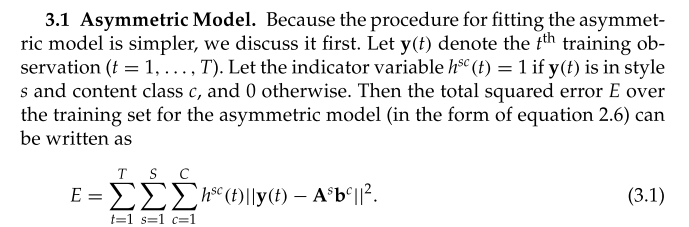
- Symmetric model: 
    - 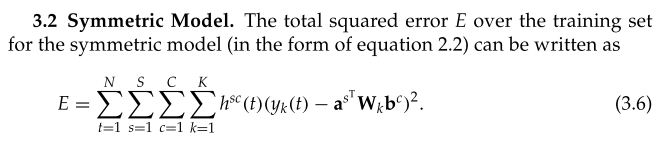
    

In [ ]:
def get_asym_eigenbasis(A: Union[torch.tensor, np.ndarray],
                        s: int,
                        j: int,
                        x_dim: int,
                        reshape: Iterable=None):
    """
    A (torch.tensor or np.ndarray): a set of asymmetric model's style-specific eigenbasis
        - shape: (n_styles * x_dim) * dim_content
        
    s (int): style label; must be in range[0,n_styles)
    cj (int): index of the element in a content vector; must be in range [0, J=dim_content]
    x_dim (int): a data variable's dimensionality; eg. number of pixels
    
    Returns:
    - w_sj (torch.tensor or np.ndarray): dim_style * dim_content matrix that corresponds to 
        the eigenbasis of the style s for the jth content dimension.
    
    """
    w = A[s*x_dim:(s+1)*x_dim, j]
    if reshape is not None:
        return w.reshape(reshape)
    else:
        return w
    
def test_get_asym_eigenbasis(A):
    plt.imshow(get_asym_eigenbasis(A, 0,0,x_dim,TARGET_SIZE),
              cmap='gray')

In [ ]:
def plot_2d_arrs(arrs: Iterable, title=None, cmap='gray'):
    f, ax = plt.subplots(1, len(arrs))
    ax = ax.flatten()
    if title is not None:
        f.suptitle(title)
    for i, arr in enumerate(arrs):
        if not isinstance(arr, np.ndarray):
            arr = np.array(arr)
        ax[i].imshow(arr, cmap=cmap)
        minv, maxv = arr.min(), arr.max()
        ax[i].set_title(f'{minv:.3f}, {maxv:.3f}')
        
    f.tight_layout()
    return f

## SGD for symmetric model:
- hyperparam: dimensionalities I, J of the style variable (a_s) of the content variable (b_c)
- model parameters:
    - the tensor B for all content vectors: (J x C)
    - tenstor A for all style vectors: (I x S)
- Rmb: X is the data matrix that contains one image for each (s,c). 

### Initialize the model parameters (as torch.tensor)
- Experiment: Use the SVD solution as the initial values of the tensors of model parameters

In [ ]:

debug = False
dim_style = 14 #I
# dim_content = 4 #J
# n_contents = 4
# model_name = f'sgd_img:{TARGET_SIZE[0]}x{TARGET_SIZE[1]}_numAngles:{len(h_angles)}_dimc:{dim_content}'

# Init method 1
# A = torch.randn((dim_style, n_styles), requires_grad=True)
# B = torch.randn((dim_content, n_contents), requires_grad=True)
# W = torch.randn((x_dim, dim_style, dim_content))

# Init method 2: 
# Load SVD solutions for the asymmetric model above
# and, use as the initial values of (some) model parameters
svd_model_dir = Path('./trained/img:64x64-nc:6-dc:6')
time_str = '10_31_19:01:12'
U,S_diag,VT = load_svd_results(svd_model_dir, time_str)
S = np.zeros((len(X),n_contents), dtype=DTYPE) 
S[:n_contents, :n_contents] = np.diag(S_diag)

A = np.matmul(U,S)[:,:dim_content] # Use it as the initialization of W for symmetric model
s, j = 0, -1
w_init = get_asym_eigenbasis(A, s=s, j=j, x_dim=x_dim, reshape=(x_dim,1,1)).astype(DTYPE)
B = VT[:dim_content,:]

# Show the w_init
# plt.imshow(w_init.reshape(TARGET_SIZE), cmap='gray')

# A,B,W for the sym. model parameters that will be optimized with SGD
# --delete big matrices that have done their duties
# del A, B
W = np.tile(w_init, (1, dim_style, dim_content)) # W.shape == (x_dim, dim_style, dim_content)
W = torch.from_numpy(W).requires_grad_(True)
A = torch.randn((dim_style, n_styles), requires_grad=True) # A.shape == (dim_style, n_styles)
B = torch.from_numpy(B).requires_grad_(True) # B.shape == (dim_content, n_contents)

if isinstance(X, np.ndarray):
    X = torch.from_numpy(X)

# Rename model name for symmetric model via SGD
model_name = f'sym_sgd_img:{TARGET_SIZE[0]}-ns:{n_styles}-ds:{dim_style}-nc:{len(h_angles)}-dc:{dim_content}'
model_dir = Path(f'./trained/{model_name}')
model_dir.mkdir(exist_ok=True, parents=True)
print(model_name)

In [ ]:
# Visualize initial parameters in A, B, W[0]
arrs = [A.detach().numpy(), B.detach().numpy(), W[0].detach().numpy()] 
plot_2d_arrs(arrs);
plt.show()

plt.imshow(W[:,0,0].detach().numpy().reshape(TARGET_SIZE), cmap='gray')

plt.show()

### Train

In [ ]:
# Learning hyperparams
loss_fn = torch.nn.MSELoss(reduction='sum')
learn_rate = 1e-3
optimizer = optim.Adam([A,B,W], lr=learn_rate)
n_epoches = 150
print_every = 30

# Debug setup
debug = True
show_i, show_j = 1,2
if debug:
    plt.imshow(W[:,show_i,show_j].detach().numpy().reshape(TARGET_SIZE), cmap='gray')
    plt.title(f'Initial W[:,{show_i}, {show_j}]')
    plt.show()
          
W_prev = None
t0 = time.time()
# Mini-batch size = 1
losses = []
for ep in range(n_epoches):
    if len(losses) > 0 and (ep+1)%print_every == 0:
#         plt.plot(losses)
        plt.plot(losses[-(n_styles*n_contents):])
        plt.title(f'Epoch: {ep+1}')
        plt.show()
        
    # One epoch
    for s in range(n_styles):
        for c in range(n_contents):
            # select c and s vectors
            a = A[:,s]
            b = B[:,c]
            Wb = W@b[..., np.newaxis]
            x_hat = torch.matmul(a,Wb).flatten()
            loss = loss_fn(x_hat, X[s*x_dim:(s+1)*x_dim, c])

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            # check if gradient doesn't go wacky
            if torch.isnan(A.grad).any() or torch.isnan(B.grad).any():
                print(s,c)
                pdb.set_trace()

            # visualize the changes in the parameters or .grad's magniture for each model parameter tensor
            if False:
#             if debug:
#                 print(Wb.shape)
#                 print(x_hat.shape)
                print(loss.item())
    #             print(A.grad.shape, B.grad.shape)
                print(f"A.grad: {torch.norm(A.grad).item()}, B.grad: {torch.norm(B.grad).item()}")
                
                # Visualize parameters in A, B, W[0]
                arrs = [A.detach().numpy(), B.detach().numpy(), W[0].detach().numpy()] 
                plot_2d_arrs(arrs, title=f'Ep: {ep}, {c}, {s}')
                plt.show()
                
                # Visualize grad of parameters in A, B, W[0]
                arrs = [A.grad.detach().numpy(), B.grad.detach().numpy(), W.grad[0].detach().numpy()] 
                plot_2d_arrs(arrs, title=f'Grad. Ep {ep}: ({c}, {s})')
                plt.show()
                
                pdb.set_trace()
                
    if debug and (ep+1)%print_every == 0:
        # Visualize current W[:,0,0]
        W_curr = W.detach().numpy().copy()
        if W_prev is not None:
            print('W prev vs current: ', np.allclose(W_prev, W_curr))
        plt.imshow(W[:,show_i, show_j].detach().numpy().reshape(TARGET_SIZE), cmap='gray')
        #todo: show other c,s positions
        plt.title(f'Ep: {ep+1}, dim_style, content: {show_i, show_j}')
        plt.show()
            
        W_prev = W_curr
#             pdb.set_trace()
time.strftime("%H:%M:%S", time.gmtime(time.time()-t0))

### Test np.matmal's broadcasting rules
- Src: [official doc](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html)

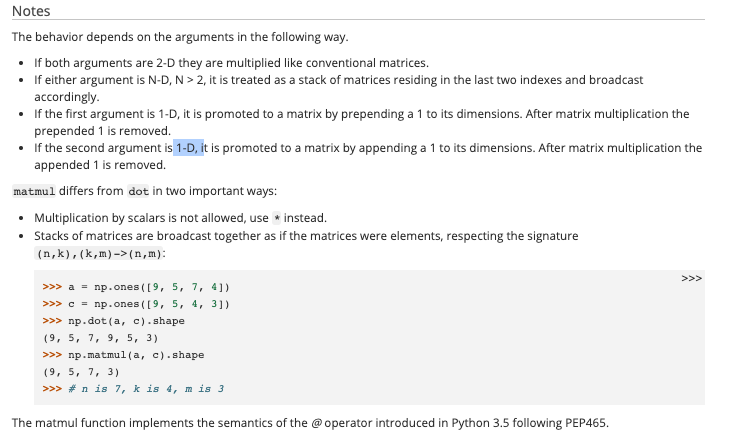

In [ ]:
# a = np.ones(3); #a[1:] = 0;
# b = np.ones(2); b[1]=0;
# W = np.ones((4,3,2))
# for k in range(len(W)):
#     W[k,:,:] = k
    

In [ ]:
# Wb = W@b[..., np.newaxis]
# print((W@b).shape)
# print((W@b)[..., np.newaxis].shape)
# # print((W@b)[..., np.newaxis])

In [ ]:
# out = np.matmul(a,Wb)
# print(out.shape)
# print(out)

## Visualize the results of the symmetric model 
- Trained via SGD
- A: a set of leanred style vectors
- B: a set of learned content vectors
- W: a tensor of learned interaction weights; same weights regardless of the content or style classes


1. Leanred style vectors  and content vectors
2. Learned interaction weights


In [ ]:
print(model_name)

#Plot style vectors
f, ax = plt.subplots(nrows=n_styles, 
                     ncols=1,
                     figsize=(3*1, 3*n_styles))
ax = ax.flatten()
f.suptitle('Learned style vectors') #style=person_id
ylim = (A.detach().numpy().min(), A.detach().numpy().max())
for s in range(n_styles):
    ax[s].bar(range(dim_style), A.detach().numpy()[:, s], label=f'Style {s}')
    ax[s].set_title(f'$Style {s}$')
    ax[s].set_ylim(ylim)
# f.tight_layout()
plt.show()        
        
# Save as figures
out_dir = Path(f'./results/{model_name}')
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

# Save A
out_fn = out_dir/'A.png'
if out_fn.exists():
    out_fn = out_dir/f'A_{now2str()}'
f.savefig(out_fn)

In [ ]:
#Plot content vectors
f, ax = plt.subplots(nrows=1, 
                     ncols=n_contents,
                     figsize=(3*n_contents, 3*1))
ax = ax.flatten()
f.suptitle('Learned content vectors') #style=person_id
ylim = (B.detach().numpy().min(), B.detach().numpy().max())
for c in range(B.shape[-1]):
    ax[c].bar(range(B.shape[0]), B.detach().numpy()[:, c], label=f'Content {c}')
    ax[c].set_title(f'Content {c}')
    ax[c].set_ylim(ylim)
f.tight_layout()
plt.show()        

# Save as figures
out_dir = Path(f'./results/{model_name}')
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

# Save B as figure 
out_fn = out_dir/'B.png'
if out_fn.exists():
    out_fn = out_dir/f'B_{now2str()}'
f.savefig(out_fn)

In [ ]:
#Plot
f, ax = plt.subplots(nrows=dim_style, 
                     ncols=dim_content,
                     figsize=(3*dim_content,3*dim_style))
f.suptitle('Symmetric interaction weights (eigenfaces)') #style=person_id
for i in range(dim_style):
    for j in range(dim_content):
        ax[i,j].imshow(W[:,i,j].detach().numpy().reshape(TARGET_SIZE), cmap='gray')
        ax[i,j].set_title(f'is,ic: {i,j}')
        ax[i,j].set_axis_off()
f.tight_layout()
plt.show()        
        
# Save W as figure 
out_fn = out_dir/'W.png'
if out_fn.exists():
    out_fn = out_dir/f'W_{now2str()}'
f.savefig(out_fn)

In [ ]:
def copy_as_np(t):
    return t.detach().numpy().copy()

In [ ]:
# Reconstruct from symmetric model
def reconstruct_sym(A:np.ndarray, B:np.ndarray, W:np.ndarray) -> np.ndarray:
    """
    A (np.array): dim_style x n_styles sized matrix encoding the  style vectors
    B (np.array): a set of content vectors. Each column is a content vector. Size: dim_content x n_contents
    W (np.array): 3Dim matrix {w_{ijk}} of size (K=x_dim, dim_style, dim_content)
    
    Returns:
    - recons (np.array): 3dim matrix of size (K=x_dim, n_styles, n_contents)
    """
    dim_style, n_styles = A.shape
    dim_content, n_contents = B.shape
    x_dim, I, J = W.shape
    assert dim_style == I
    assert dim_content == J
    
    recons = np.zeros((x_dim, n_styles, n_contents))
    for s in range(n_styles):
        for c in range(n_contents):
            a = A[:,s].transpose()
            b = B[:,c].transpose()
            Wb = W@b[..., np.newaxis]
            assert Wb.ndim == 3 # Necessary for correct broadcasting for the subsequent `np.matmul`
            recons[:, s, c] = np.matmul(a,Wb).flatten()
            
    return recons

In [ ]:
def plot_recons(recons: np.ndarray, reshape: Optional[Tuple[int,int]], title=None):
    """
    recons (np.ndarray): size (x_dim, n_styles, n_contents)
    reshape (None or Tupel of target image size)
    """
    _, n_styles, n_contents = recons.shape
    f, ax = plt.subplots(nrows=n_styles, ncols=n_contents,
                        figsize=(3*n_contents, 3*n_styles))
    if title is not None:
        f.suptitle(title)
    for s in range(n_styles):
        for c in range(n_contents):
            if reshape is None:
                ax[s][c].imshow(recons[:,s,c], cmap='gray')
            else:
                ax[s][c].imshow(recons[:,s,c].reshape(reshape), cmap='gray')
            ax[s][c].set_title(f'S,C: {s+1},{c+1}')
    return f

In [ ]:
def compute_mse(x, recon):
    """
    
    """
    pass

In [ ]:
recons = reconstruct_sym(copy_as_np(A), copy_as_np(B), copy_as_np(W))

In [ ]:
f_recon = plot_recons(recons, reshape=TARGET_SIZE, title='Reconstruction');

In [ ]:
# Save W as figure 
out_fn = out_dir/'recon.png'
if out_fn.exists():
    out_fn = out_dir/f'recon_{now2str()}'
f_recon.savefig(out_fn)

### Save trained model

In [ ]:
# sgd_model_dir = 
save_sgd_results(A,B,W, out_dir=model_dir)

## Visualize model learned via SVD

## Show the learned set of style-specific eigenfaces
$A$ is the $(S \times K) \times dim_c (=J)$ matrix, which encodes the learned style-specific eigenfaces.
$B$ is the $dim_c=J \times C$ matrix, each of whose column is a learned content vector 
    - For each content vector, let's see the coordinate distribution

In [ ]:
print(model_name)

#Plot
f, ax = plt.subplots(nrows=n_styles, 
                     ncols=dim_content,
                     figsize=(3*dim_content,3*n_styles))
f.suptitle('Style-specific eigenbasis for content dimension') #style=person_id
for s in range(n_styles):
    for ic in range(dim_content):
        ax[s,ic].imshow(A[s*x_dim:(s+1)*x_dim, ic].reshape(TARGET_SIZE), cmap='gray')
        ax[s,ic].set_title(f'$c_{ic}$')
        ax[s,ic].set_axis_off()
f.tight_layout()
plt.show()        
        
    
# Save figure 
out_dir = Path(f'./results/{model_name}')
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

out_fn = out_dir/'A'
if out_fn.exists():
    out_fn = out_dir/f'A_{now2str()}'
f.savefig(f'./results/{model_name}/A')


## Show the learned set of content classes
$B$ is the $dim_c (=J) \times C$ matrix; each column is a learned content vector for a specific content class (representation)
- For each content vector, let's see the coordinate distribution
- Q: If the model learns a factorized representation of the content variable, each dimension of the content variable will have a specific function in explaining the variations in the content information in the data variables.

In [ ]:
assert B.shape[1] == n_contents

# f, ax = plt.subplots(nrows=2, ncols=math.ceil(n_contents/2))
f, ax = plt.subplots(nrows=1, ncols=n_contents, figsize=(26,1))

ax = ax.flatten()
for i in range(n_contents):
    c = B[:,i]
#     ax[i].bar(range(len(c)), c, label=f'Content {i}')
    ax[i].bar(range(len(c)), c.detach().numpy(), label=f'Content {i}')

    ax[i].set_title(f'Content {i+1}')
# print(i)
# if i<len(ax):
#     # Delete unused axes
#     for j in range(i, len(ax)):
#         f.delaxes(ax[j])
    
# Save figure 
out_dir = Path(f'./results/{model_name}')
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

out_fn = out_dir/'B' 
if out_fn.exists():
    out_fn = out_dir/f'B_{now2str()}'
f.savefig(f'./results/{model_name}/B')

## Evaluation: by looking at the reconstructed images


In [ ]:
def save_figure(f, out_dir, fname):
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)
        print(f'{out_dir} is created.')
    
    out_fn = out_dir/fname 
    if out_fn.exists():
        out_fn = out_dir/f'{fname}_{now2str()}'
        
#     pdb.set_trace()
    f.savefig(out_fn)

In [ ]:
def visualize_x(X, dim_x, target_size, title=None):
    """
    Args:
    - X (np.array): data matrix of size (num_styles x dim_data_var) x num_contents
    - dim_x (int): dimensionality of a data variable (ie. K in the paper)
    - target_size (tuple): (height,width) of the images
    """
    SK, C = X.shape
    S = int(SK/dim_x)
    n_imgs = S*C
    
    f,ax = plt.subplots(nrows=S, ncols=C, figsize=(3*C,3*S))
    if title is not None:
        f.suptitle(title)
    for i in range(S):
        for j in range(C):
            recon = X[i*dim_x:(i+1)*dim_x, j]
            if S>1:
                ax[i][j].imshow(recon.reshape(target_size), cmap='gray')
            else:
                ax[j].imshow(recon.reshape(target_size), cmap='gray')
            
            if i==0 and j==0:
                info(recon)
#                 pdb.set_trace()
    return f,ax
                

In [ ]:
X_recon = np.matmul(A,B)



In [ ]:
f_recon, _ = visualize_x(X_recon, x_dim, TARGET_SIZE, title='Reconstruction');

In [ ]:
out_dir = Path(f'./results/{model_name}')
save_figure(f_recon, out_dir, 'recon')

In [ ]:
f_input, ax = visualize_x(X, x_dim, TARGET_SIZE, title='input')
save_figure(f_input, out_dir, 'input')

##  Evaluation: Generalization task.
Steps:
- Choose a style s. 
- Choose two/multiple content vectors learned during the training phase.
- Using the eigenfaces for the style s, reconstruct for each content vectors (ie. for each pose)
- Check if the reconstructed images show the same person (ie. same style), while each of which has distinct content (ie. different poses).  

This evaluation is already shown with the matrix of the reconstructed images: For each style (ie. each row), the reconstrcution matrix shows how various contents (poses) are being stylized according to the chosen style (ie. person's identity). We see our model has correctly learned to generalize(?) each style to any of the contents (seen during the training phase) by noting that all images in the same row maintains the same identity of the chosen person $s$, while chaing the poses (ie. different contents).


------------------------------------------------------------------------
- Q1: is each of the content vector (learned from the training dataset) normalized?
- Q2: What happens if we randomly walk around the content space and reconstruct images?
- Q3: Can we reconstruct a specific pose (eg.  pose = straight ahead) of two mixed (with tuned weights) styles(ie. some interpolation of two people)?

In [ ]:
# Q1
B.sum(axis=0)

In [ ]:
# Q2

Xtemp = np.zeros_like(X_recon)
B_onehot = np.zeros_like(B)
for ic in range(dim_content):
    B_onehot[ic,ic] = 1.0
#     pdb.set_trace()
#     Xtemp


In [ ]:
X_onehot = np.matmul(A, B_onehot)
f_onehot, _ = visualize_x(X_onehot, x_dim, TARGET_SIZE, title='Onehot Reconstruction');

In [ ]:
# Q3
# First select two styles
s1, s2 = 0,1
w1, w2 = 0.3, 0.7 
s = w1*A[s1*x_dim:(s1+1)*x_dim,:] + w2*A[s2*x_dim:(s2+1)*x_dim,:] # interpolated style
s

In [ ]:
X_interp = np.matmul(s, B)


In [ ]:
visualize_x(X_interp, x_dim, TARGET_SIZE, title=f'${w1}s1 + {w2}s2$')

## Sec 4: Real generalization (reserved one style from training and use it for learning during testing phase)
- [ ] 

In [ ]:
def get_norm(M):
    "Compute each column vector's length"
    

------------------------------------------------------------------------
## Tasks
- [ ] try with maptile (128x128)
- [ ] Reconstruction
- [ ] Fix a stlye vector to a value. Vary the content variable values. Reconstruct and see if the reconstructions is of the same person
- [ ] Inspect the learned manifold / latent space via interpolation 
    - 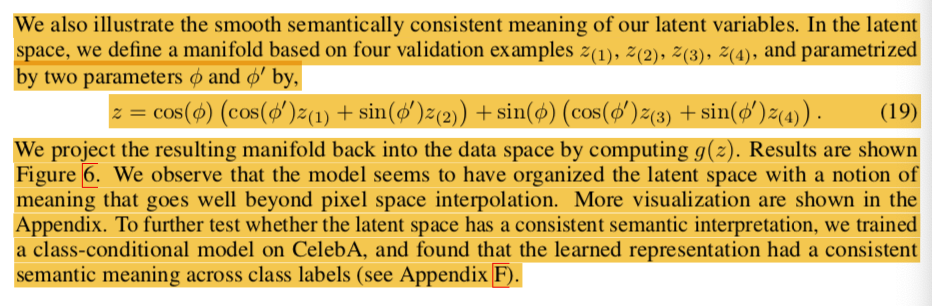
    - 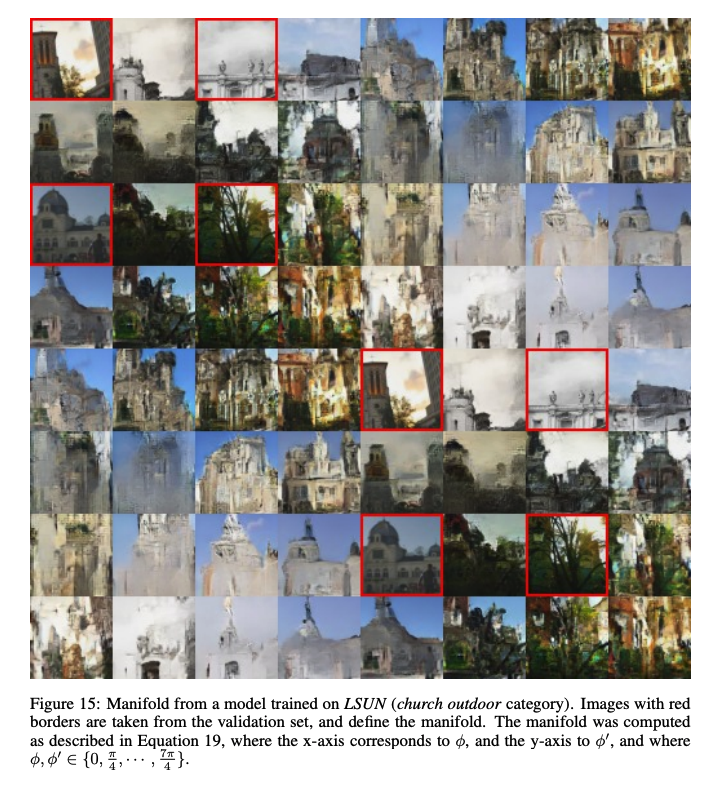
    - Src: [Dinh2017-RealNVP](https://www.semanticscholar.org/paper/Density-estimation-using-Real-NVP-Dinh-Sohl-Dickstein/09879f7956dddc2a9328f5c1472feeb8402bcbcf) Eqn19 and Appendix E


In [ ]:
def get_new_z(z1, z2, z3, z4, phi1, phi2):
    """
    Create a new point in the space with the same dimension as z1 and z2 by 
    the interpolation equation (Eqn19 as described in Dinh2017-RealNVP paper):
    $z = cos(\phi_1)* (cos(\phi_2)z^{(1)} + sin(\phi_2)z^{(2)}) 
       + sin(\phi_1)* (cos(\phi_2)z^{(3)} + sin(\phi_2)z^{(4)}) $
    
    Args:
    - z1 (np.array): 1-Dim vector as the latent representation of a data pt
    - z2 (np.array): 1-Dim vecotr as the latent representation of another data pt.
    - phi1 (float): a parameter to inspect the latent manifold in x-axis's nob
    - phi2 (float): a parameter as the nob in y-axis 
        - phi1 and phi2 are in {0, pi/4, ..., 7pi/4}: 8 values in each x/y-axis
        
    Returns:
    - z (np.array): an interpolated point in the latent space
    """
    term12 = (np.cos(phi2) * z1 + np.sin(phi2) * z2)
    term34 = (np.cos(phi2) * z3 + np.sin(phi2) * z4)
    return np.cos(phi1)*term12 + np.sin(phi1)*term34
    

In [ ]:
def visualize_latent_manifold(As: np.array, 
                       z1, 
                       z2, 
                       z3, 
                       z4, 
                       phi1s=None, 
                      phi2s=None,
                      img_size: Iterable=None
                      ):
    """
    - As (np.array): a learned set of style-specific eigenfaces, of size (S=1 * K)*J.
    - img_size: tuple of height, width 
    
    We can get a set of reconstructed image of a specific content z 
    with each and all of the styles via:
    
    X_recon = As * z where z is a column vector of len = dim_content
    
    
    """
    if phi1s is None:
        phi1s = [i*np.pi/4 for i in range(8)]
    if phi2s is None:
        phi2s = [i*np.pi/4 for i in range(8)]
    if img_size is None:
        img_size = (64,64)
    f,ax = plt.subplots(nrows=len(phi2s), ncols=len(phi1s), 
                        figsize=(3*len(phi1s),3*len(phi2s)))
#     ax = ax.flatten()
    for irow,phi2 in enumerate(phi2s):
        for icol,phi1 in enumerate(phi1s):
            z = get_new_z(z1, z2, z3, z4, phi1, phi2) #eg. interpolated content vector
            X_recon = np.matmul(As,z) # this will change if we use a generative network as the decoder
#             print(X_reconc.shape)
#             pdb.set_trace()
#             assert len(X_recon) == x_dim
            img = X_recon.reshape(img_size)
            ax[irow][icol].imshow(img, cmap='gray')
            ax[irow][icol].set_title(f'{phi2:.3f, phi1}')
            

In [ ]:
s = 1

z1 = B[:,0] 
z2 = B[:,1]
z3 = B[:,2]
z4 = B[:,3]
visualize_latent_manifold(A[s*x_dim:(s+1)*x_dim, :], z1, z2, z3, z4, img_size=TARGET_SIZE)

### Explore the latent space via linear interpolation

Alternatively, in the [DCGAN]() paper, the authors explored the latent space by linear interpolation between two latent vectors that correspond to two data points in the training set. 
- Src: [blog:mlmastery](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)


In [ ]:
def linear_interpolate(z1, z2, phi1):
    """
    Get a new point z as a linear interpolation of the two vectors
    """
    z = phi1*z1 + (1-phi1)*z2
    return z


In [ ]:
def visualize_lin_interp(As: np.array, 
                       z1, 
                       z2, 
                      img_size,
                         title=None
                      ):
    """
    - As (np.array): a learned set of style-specific eigenfaces, of size (S=1 * K)*J.
    - img_size: tuple of height, width 
    
    We can get a set of reconstructed image of a specific content z 
    with each and all of the styles via:
    
    X_recon = As * z where z is a column vector of len = dim_content
    
    
    """
    nrows, ncols = 1,8
    phi1s = np.linspace(0,1,num=nrows*ncols)

    f,ax = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(5*ncols,5*nrows))
    if title is not None:
        f.suptitle(title)
        
    ax = ax.flatten()
    for i, phi1 in enumerate(phi1s):
        z = linear_interpolate(z1,z2,phi1)
        X_recon = np.matmul(As,z)
        img = X_recon.reshape(img_size)
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(f'{phi1:.3f}')
        ax[i].set_axis_off()
        
    f.tight_layout()
    return f
                    
            

In [ ]:
result_dir = Path(f'./results/{model_name}')
if not result_dir.exists():
    result_dir.mkdir(parents=True)


s = 0

z1 = B[:,0] # -75 angle
z2 = B[:,1] # -45
z3 = B[:,2] # 45
z4 = B[:,3] # 75
f1 = visualize_lin_interp(A[s*x_dim:(s+1)*x_dim, :], z1, z2, img_size=TARGET_SIZE, 
                     title='Linear Interpolation in latent space: c1, c2');
f2 = visualize_lin_interp(A[s*x_dim:(s+1)*x_dim, :], z3, z4, img_size=TARGET_SIZE, 
                     title='Linear Interpolation in latent space: c3, c4');

f1.savefig(result_dir/f'lin_interp_c1_c2_s{s}')
f2.savefig(result_dir/f'lin_interp_c3_c4_s{s}')

- [x] this indeed show the latent space is linearlly semantically meaningful --> write a paragraph --> Done in [Disjoint subsets of latent variables - content vs. style groups w/ Table: maptile dataset](https://uscedu-my.sharepoint.com/personal/haejinso_usc_edu/Documents/Hae%20Jin%20@%20University%20of%20Southern%20California/Daily%20Reviews.one#Disjoint%20subsets%20of%20latent%20variables%20-%20content%20vs.%20style%20groups&section-id={E32CA149-9E06-BE49-A691-986D5137AFD6}&page-id={991D6B6D-D5D5-394B-81AE-9DE0A875B810}&end)  ([Web view](https://uscedu-my.sharepoint.com/personal/haejinso_usc_edu/_layouts/OneNote.aspx?id=%2Fpersonal%2Fhaejinso_usc_edu%2FDocuments%2FHae%20Jin%20%40%20University%20of%20Southern%20California&wd=target%28Daily%20Reviews.one%7CE32CA149-9E06-BE49-A691-986D5137AFD6%2FDisjoint%20subsets%20of%20latent%20variables%20-%20content%20vs.%20style%20groups%7C991D6B6D-D5D5-394B-81AE-9DE0A875B810%2F%29))


### Vector arithemetics using learned content vectors
Let $c = c^{(-75)} - c^{(75)}$. Check if $As*c$ is the reconstruction of person $s$ at pose =-75+75=0.


In [ ]:
z1 = B[:,0] 
z4 = B[:,-1]

In [ ]:
z = z1 - z4
s = 0
X_z = np.matmul(A[s*x_dim:(s+1)*x_dim, :], z)
plt.imshow(X_z.reshape(TARGET_SIZE), cmap='gray')

Nah, doesn't seem to have learned the semantics.. okay. This will be another things to check with the VAE model to see if VAE learns the latent space that allows the semantic arithematics in the latent space (for the content). 

But, the Tenanbaum2000 also shows interesting way to generalize the model to move content to different/unseen styles -- which is discussed in Sec 4. Now let's focus on Sec 4. 

- [ ] Sect. 4: Generalization Tasks

### Explore the latent space by traversing the manifold with spherically interpollated points 

$$
\theta = angle(z0, z1)
sin(\theta) h(t) = sin((1-t)\theta)z0 + sin(t\theta)z1 , t \in [0,1]
$$

- 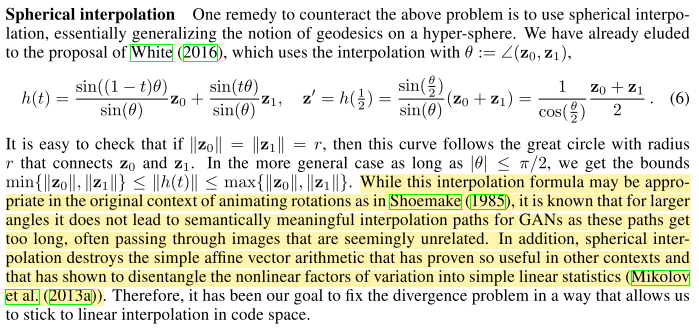
    - src: Semantic Interpolation in Implicit Models 

---

- For a better implementation of the spherical interpolation that uses a linear interpolation in case when the spherical interpolation fails (ie. , refer to 
    - [mlmastery](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/#caption-attachment-8147:~:text=spherical%20linear%20interpolation%20function) and,
    - [soumith/dcgan.torch](https://github.com/soumith/dcgan.torch/issues/14):
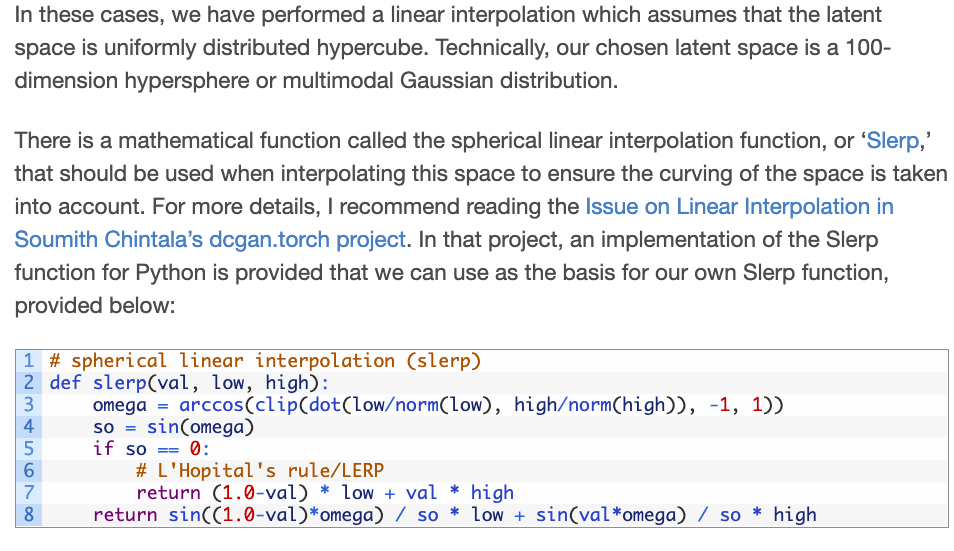

In [ ]:
def normalize(v: Iterable) -> Iterable:
    if np.isclose(np.linalg.norm(v),0):
        return v
    else:
        return v/np.linalg.norm(v)

In [ ]:
def get_angle(u: Iterable, v: Iterable):
    unit_u = normalize(u)
    unit_v = normalize(v)
    cos_theta = np.dot(unit_u, unit_v)
    theta = np.arccos(np.clip(cos_theta, -1, 1))
#     if abs(theta) > np.pi/2:
#         raise ValueError("Angle btw the two vectors should be <90 degrees: "
#                          f"{theta*180/np.pi:.2f}")
    return theta
    
    
def test_get_angle_3d():
    assert np.isclose(np.pi/2, get_angle([1,0,0], [0,1,0]))
    assert np.isclose(np.pi/2, get_angle([1,0,0], [0,0,1]))
    assert np.isclose(np.pi/2, get_angle([0,1,0], [0,0,1]))
    
def test_get_angle_fail_180():
    get_angle([1,0,0], [-1,0,0])
def test_get_angle_fail_135():
    print (get_angle([1,0,0], [-1,-1,0]))
# test_get_angle_3d()
# test_get_angle_fail_135()

In [ ]:
def spherical_interpolate(u,v,t):
    """
    z_t = 
    """
    assert 0<=t and t<=1
    assert len(u) == len(v)
    
    angle = get_angle(u,v)
    # If abs(angle) is bigger than 90degree, the result of the interpolation is not really 
    # meaningful interpretation
    if abs(angle) > np.pi/2:
        warnings.warn("Angle btw the two vectors should be <90 degrees: "
                    f"{angle*180/np.pi:.2f}")
        
    denom = np.sin(angle)
    if np.isclose(denom,0.):
        # linear interpolation
        return linear_interpolate(u,v,t)
    
    term1 = np.sin((1-t)*angle)*u
    term2 = np.sin(t*angle)*v
    return (term1+term2)/denom

In [ ]:
def visualize_interp(As: np.array, z1, z2, 
                     interp_function: Callable, img_size, title=None):
    """
    - As (np.array): a learned set of style-specific eigenfaces, of size (S=1 * K)*J.
    - interp_function (Callable): function signature must be 
        interp_function(z1, z2, t) where t is the weighting parameter
        - eg. linear_interpolate(z1,z2,phi1)
        - eg. spherical_interpolate(z1,z2,t)
    - img_size: tuple of height, width 
    
    We can get a set of reconstructed image of a specific content z 
    with each and all of the styles via:
    
    X_recon = As * z where z is a column vector of len = dim_content
    
    
    """
    nrows, ncols = 1,8
    ts = np.linspace(0,1,num=nrows*ncols)

    f,ax = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(5*ncols,5*nrows))
    if title is not None:
        f.suptitle(title)
        
    ax = ax.flatten()
    for i, t in enumerate(ts):
        z = interp_function(z1,z2,t)
        X_recon = np.matmul(As,z)
        img = X_recon.reshape(img_size)
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(f'{t:.3f}')
        ax[i].set_axis_off()
        
    f.tight_layout()
    return f
                    
            

In [ ]:
result_dir = Path(f'./results/{model_name}')
if not result_dir.exists():
    result_dir.mkdir(parents=True)


s = 0

z1 = B[:,0] # -75 angle
z2 = B[:,1] # -45
z3 = B[:,2] # 45
z4 = B[:,3] # 75
f1 = visualize_interp(A[s*x_dim:(s+1)*x_dim, :], z1, z2,
                      spherical_interpolate,
                      img_size=TARGET_SIZE, 
                      title='Spherical Interpolation in latent space: c1, c2');
f2 = visualize_interp(A[s*x_dim:(s+1)*x_dim, :], z3, z4, 
                      spherical_interpolate,
                      img_size=TARGET_SIZE, 
                      title='Spherical Interpolation in latent space: c3, c4');

f1.savefig(result_dir/f'spheric_interp_c1_c2_s{s}')
f2.savefig(result_dir/f'spheric_interp_c3_c4_s{s}')